In [1]:
import numpy as np
import matplotlib.pyplot as plt

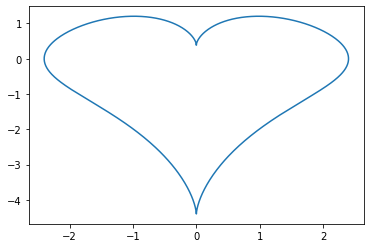

In [4]:
# Display heart shape function
t = np.linspace(0, 2 * np.pi, 1000)
xs = 2.4 * np.sin(t) ** 3
ys = 2.4 * np.cos(t) - 2 * np.cos(t) ** 4

plt.plot(xs, ys)

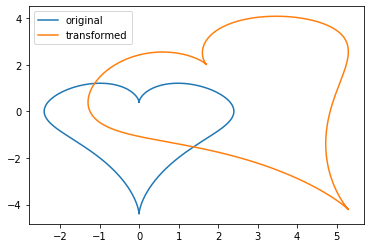

In [10]:
# display rotation and translation function
scale = 1.5
angle = np.pi / 6
translation = (2.0, 1.5)
rotation_mat = np.array([
    [np.cos(angle), -np.sin(angle)],
    [np.sin(angle), np.cos(angle)],
])
rot_points = rotation_mat @ np.concatenate((xs[None, :], ys[None, :]), axis=0)
rot_xs = scale * rot_points[0, :] + translation[0]
rot_ys = scale * rot_points[1, :] + translation[1]

plt.plot(xs, ys, label='original')
plt.plot(rot_xs, rot_ys, label='transformed')
plt.legend()

In [23]:
# This function is carbon copy from https://stackoverflow.com/questions/18925181/procrustes-analysis-with-numpy
def procrustes(X, Y, scaling=True, reflection='best'):
    """
    A port of MATLAB's `procrustes` function to Numpy.

    Procrustes analysis determines a linear transformation (translation,
    reflection, orthogonal rotation and scaling) of the points in Y to best
    conform them to the points in matrix X, using the sum of squared errors
    as the goodness of fit criterion.

        d, Z, [tform] = procrustes(X, Y)

    Inputs:
    ------------
    X, Y    
        matrices of target and input coordinates. they must have equal
        numbers of  points (rows), but Y may have fewer dimensions
        (columns) than X.

    scaling 
        if False, the scaling component of the transformation is forced
        to 1

    reflection
        if 'best' (default), the transformation solution may or may not
        include a reflection component, depending on which fits the data
        best. setting reflection to True or False forces a solution with
        reflection or no reflection respectively.

    Outputs
    ------------
    d       
        the residual sum of squared errors, normalized according to a
        measure of the scale of X, ((X - X.mean(0))**2).sum()

    Z
        the matrix of transformed Y-values

    tform   
        a dict specifying the rotation, translation and scaling that
        maps X --> Y

    """

    n,m = X.shape
    ny,my = Y.shape

    muX = X.mean(0)
    muY = Y.mean(0)

    X0 = X - muX
    Y0 = Y - muY

    ssX = (X0**2.).sum()
    ssY = (Y0**2.).sum()

    # centred Frobenius norm
    normX = np.sqrt(ssX)
    normY = np.sqrt(ssY)

    # scale to equal (unit) norm
    X0 /= normX
    Y0 /= normY

    if my < m:
        Y0 = np.concatenate((Y0, np.zeros(n, m-my)),0)

    # optimum rotation matrix of Y
    A = np.dot(X0.T, Y0)
    U,s,Vt = np.linalg.svd(A,full_matrices=False)
    V = Vt.T
    T = np.dot(V, U.T)

    if reflection is not 'best':

        # does the current solution use a reflection?
        have_reflection = np.linalg.det(T) < 0

        # if that's not what was specified, force another reflection
        if reflection != have_reflection:
            V[:,-1] *= -1
            s[-1] *= -1
            T = np.dot(V, U.T)

    traceTA = s.sum()

    if scaling:

        # optimum scaling of Y
        b = traceTA * normX / normY

        # standarised distance between X and b*Y*T + c
        d = 1 - traceTA**2

        # transformed coords
        Z = normX*traceTA*np.dot(Y0, T) + muX

    else:
        b = 1
        d = 1 + ssY/ssX - 2 * traceTA * normY / normX
        Z = normY*np.dot(Y0, T) + muX

    # transformation matrix
    if my < m:
        T = T[:my,:]
    c = muX - b*np.dot(muY, T)

    #transformation values 
    tform = {'rotation':T, 'scale':b, 'translation':c}

    return d, Z, tform

0.0

(1000, 2)

{'rotation': array([[ 0.8660254, -0.5      ],
        [ 0.5      ,  0.8660254]]),
 'scale': 0.6666666666666667,
 'translation': array([-1.65470054, -0.19935874])}

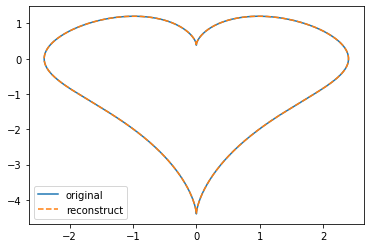

In [32]:
# Solve procrustes problem by closed form
from scipy.linalg import orthogonal_procrustes

basis_pts = np.concatenate([xs[:, None], ys[:, None]], axis=1)
target_pts = np.concatenate([rot_xs[:, None], rot_ys[:, None]], axis=1)

basis_center = np.mean(basis_pts, axis=0)
target_center = np.mean(target_pts, axis=0)

disparity, reconstruct, tform = procrustes(basis_pts, target_pts)

display(d)
display(Z.shape)
display(tform)

rxs = reconstruct[:, 0]
rys = reconstruct[:, 1]
plt.plot(xs, ys, label='original')
plt.plot(rxs, rys, label='reconstruct', linestyle='--')
plt.legend()